In [12]:
import pandas as pd
from lightgbm import LGBMClassifier
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
import lightgbm as lgbm
import optuna
from sklearn.metrics import log_loss, f1_score

In [13]:
train = pd.read_csv("/home/mglee/VSCODE/Dacon/Jobcare_data/train.csv")
test = pd.read_csv("/home/mglee/VSCODE/Dacon/Jobcare_data/test.csv")
sample = pd.read_csv("/home/mglee/VSCODE/Dacon/Jobcare_data/sample_submission.csv")

In [14]:
#invert bool type variables to int

for column in train.select_dtypes(include='bool').columns:
    train[column] = train[column].astype(int)

for column in test.select_dtypes(include='bool').columns:
    test[column] = test[column].astype(int)

In [15]:
#invert str varible to datetime

train['contents_open_dt'] = pd.to_datetime(train['contents_open_dt'])
test['contents_open_dt'] = pd.to_datetime(test['contents_open_dt'])

train.sort_values(by = 'contents_open_dt', inplace = True)

In [16]:
#split datetime to day, hour, day of week

for df in [train, test]:
    df['dia'] = pd.DatetimeIndex(df['contents_open_dt']).day
    df['hora'] = pd.DatetimeIndex(df['contents_open_dt']).hour
    df['dayofweek'] = df['contents_open_dt'].dt.dayofweek

In [17]:
for df in [train, test]:
    df.drop([
        'person_prefer_g',
        'person_prefer_f'
    ],axis = 1, inplace = True)

In [18]:
y = train['target']
X = train.drop([
    'id', 'target', 'contents_open_dt'], axis = 1
)

In [19]:
################################################
##############################################
#################이거 쓰나??? #####################

###########마지막에 최종적으로 모델만들때 쓰는듯??##########

X_train, X_test, y_train, y_test =  train_test_split(
    train.drop(['id','target', 'contents_open_dt'], axis = 1), train['target'],
    test_size = 0.1, stratify = y, random_state = 42
)



In [20]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(451755, 33) (50196, 33) (451755,) (50196,)


In [21]:
cv_data = lgbm.Dataset(X, label = y)

In [22]:
#hyper parameter tune

from optuna.integration import LightGBMPruningCallback

def objective(trial, X, y):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.95, step=0.1),
        "num_leaves": trial.suggest_int("num_leaves", 5, 100, step=5),
        "max_depth": trial.suggest_int("max_depth", 1, 30, step=3),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 50, 1000, step=50),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 1, 30, step=3),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 0.99, step=0.1),
        "bagging_freq": trial.suggest_categorical("bagging_freq",[1]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 0.99, step=0.1),
        "n_estimators": trial.suggest_int("n_estimators", 10, 2000, step=10),    
    }

    ##model build
    n_splits = 5
    cv = StratifiedKFold(n_splits = n_splits, shuffle = False)

    cv_scores = np.empty(5)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = lgbm.LGBMClassifier(objective = 'binary', **param_grid)

        model.fit(
            X_train, y_train,
            eval_set = [(X_test, y_test)],
            eval_metric = 'binary_logloss',
            callbacks=[LightGBMPruningCallback(trial, "binary_logloss")],
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

In [23]:
study = optuna.create_study(direction = 'minimize', study_name = "LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials= 20)

[I 2022-01-19 17:22:47,149] A new study created in memory with name: LGBM Classifier
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.1, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.1, 0.9].
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [1, 30] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 28].
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [1, 30] and q=3, but the range is not divisible by `q`. It will be replaced by [1, 28.0].
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.1, 0.99] and q=0.1, but the range is not

[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=7.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.0
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: b

/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8

[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=7.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.0
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8

[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=7.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.0
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8

[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=7.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.0
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8

[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=10.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bag

/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8

[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=10.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8

[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=10.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8

[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=10.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8

[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=10.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.0
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: b

/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8

[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=10.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.0
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8

[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=10.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.0
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8

[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=10.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.0
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8

[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=22.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=22.0
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=450, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=450
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 wil

/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8

[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=22.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=22.0
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=450, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=450
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8

[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=22.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=22.0
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=450, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=450
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8

[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=22.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=22.0
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=450, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=450
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8

[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.7000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7000000000000001
[LightGBM] [Warning] min_gain_to_split is set=22.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=22.0
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.7000000000000001, su

/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8

[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.7000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7000000000000001
[LightGBM] [Warning] min_gain_to_split is set=22.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=22.0
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8

[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.7000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7000000000000001
[LightGBM] [Warning] min_gain_to_split is set=22.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=22.0
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8

[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.7000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7000000000000001
[LightGBM] [Warning] min_gain_to_split is set=22.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=22.0
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/mglee/.conda/envs/svmglee/lib/python3.8

KeyboardInterrupt: 

In [ ]:
print(f"\tBest Value : {study.best_value:.5f}")
print(f"\tBest params :")

for key, value in study.best_params.items():
    print(f"\t{key} : {value}")


	Best Value : 0.65117
	Best params :
	learning_rate : 0.9
	num_leaves : 100
	max_depth : 19
	min_data_in_leaf : 1000
	lambda_l1 : 100
	lambda_l2 : 5
	min_gain_to_split : 1.0
	bagging_fraction : 0.5
	bagging_freq : 1
	feature_fraction : 0.4
	n_estimators : 1370


In [ ]:
model = lgbm.LGBMClassifier(objective = 'binary', **study.best_params)
model.fit(
    X_train, y_train
)

pred = model.predict(X_test)
f1_score(y_test, pred)

0.6296055151283034

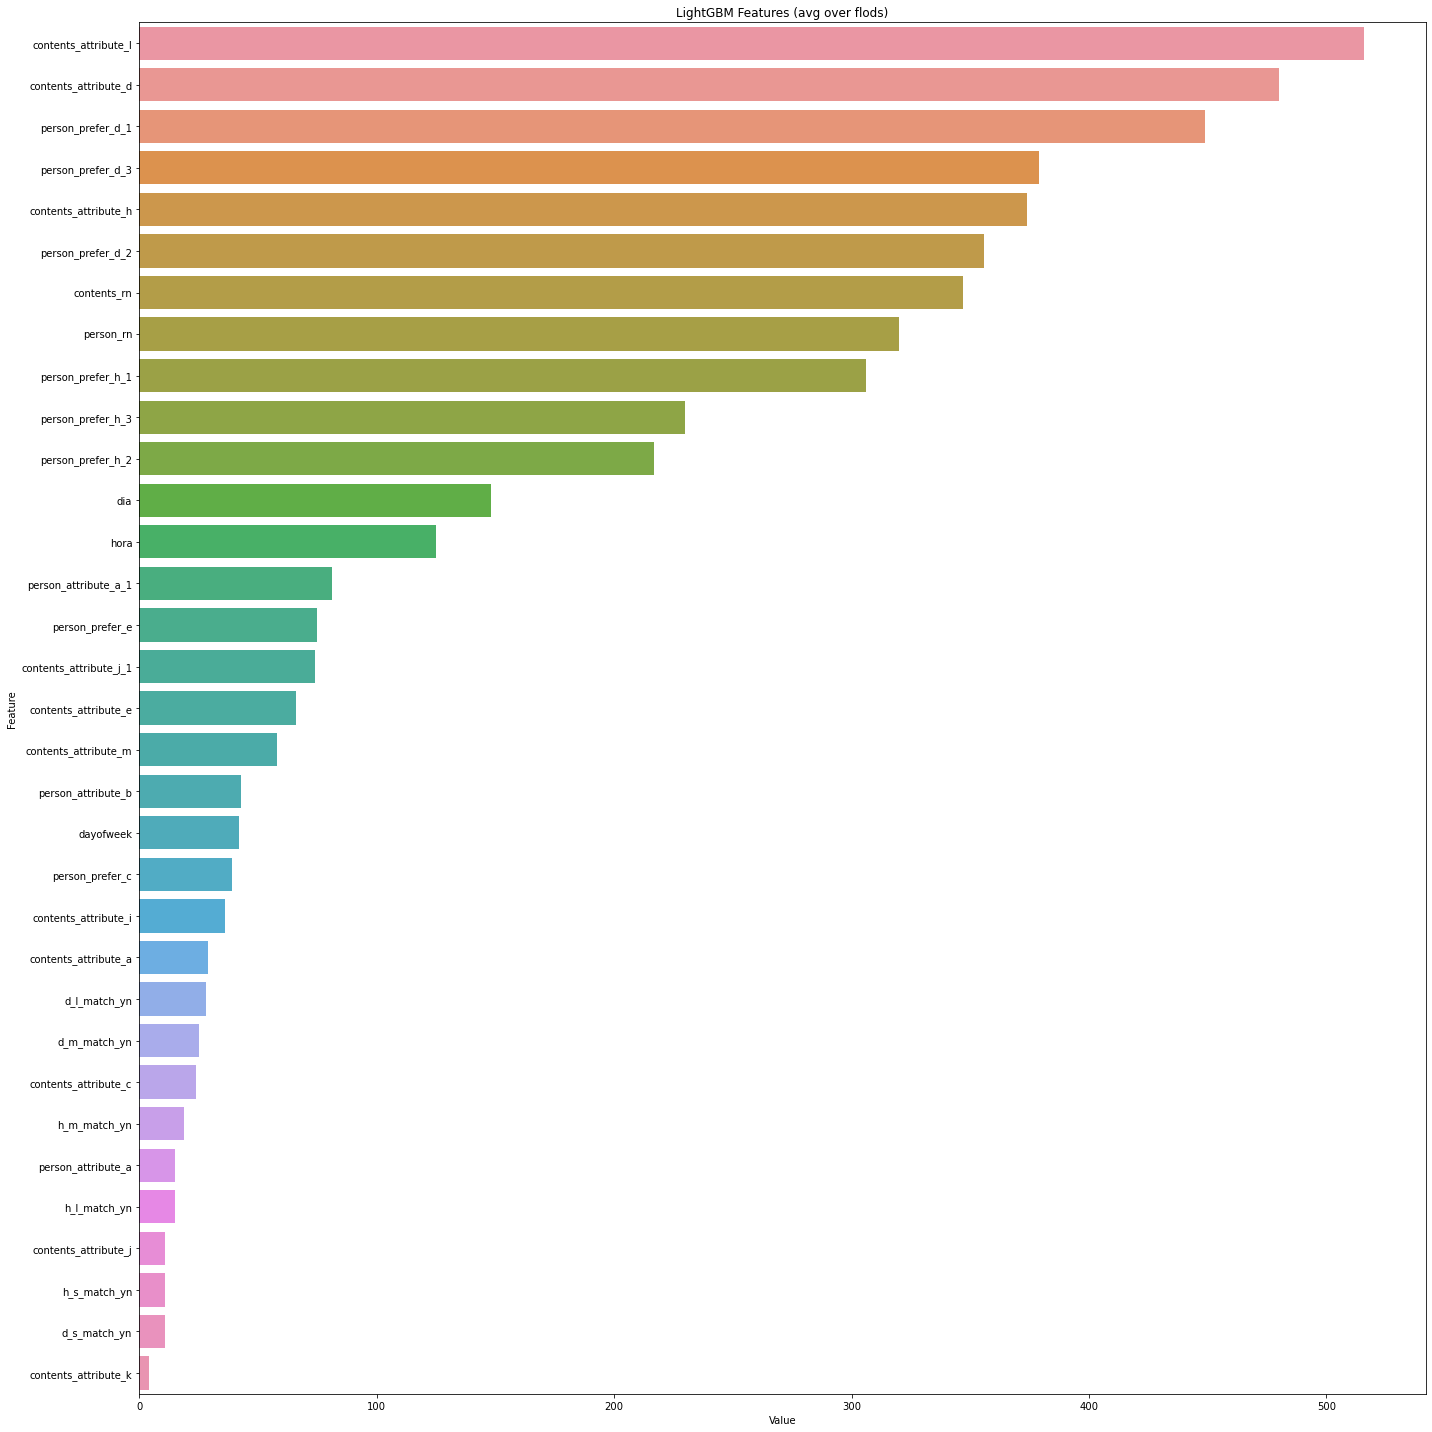

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, X.columns)), columns = ['Value', 'Feature'])

plt.figure(figsize=(20, 20))
sns.barplot(x = 'Value', y = 'Feature', data = feature_imp.sort_values(by = 'Value', ascending= False))
plt.title("LightGBM Features (avg over flods)")
plt.tight_layout()
plt.show()
plt.savefig("lgbm_importances-01.png")


In [ ]:
param = study.best_params
param['objective'] = "binary"
param['verbosity'] = 0

In [ ]:
model = lgbm.LGBMClassifier(objective="binary", **study.best_params)
model.fit(
    X,
    y
)

[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=1.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


LGBMClassifier(bagging_fraction=0.5, bagging_freq=1, feature_fraction=0.4,
               lambda_l1=100, lambda_l2=5, learning_rate=0.9, max_depth=19,
               min_data_in_leaf=1000, min_gain_to_split=1.0, n_estimators=1370,
               num_leaves=100, objective='binary')

In [2]:
pred = model.predict_proba(test.drop(['id','contents_open_dt'],axis = 1))
#pred_1 = model.predict_proba(test.drop(['id','contents_open_dt'],axis = 1))

NameError: name 'model' is not defined

In [65]:
pd.Series(pred[:,1]).to_pickle("lgbm.pkl")

In [53]:
pd.DataFrame(pred).value_counts()

1    24731
0    21673
dtype: int64

In [73]:
pred[:,1]

array([0.33554115, 0.38583919, 0.45271606, ..., 0.58671872, 0.58268285,
       0.68255518])

In [54]:
sample['target'] = pred
sample.to_csv('sub.csv',index=False)